# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Описание данных:
- calls - количество звонков;
- minutes - суммарная длительность звонков в минутах;
- messages - количество sms-сообщений;
- mb_used - израсходованный интернет-трафик в Мб;
- is_ultra - каким тарифом пользовался в течении месяца("Ультра" - 1, "Смарт" - 0)

In [43]:
#импортируем библиотеки необходимые для работы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

## Откроем и изучим файл

In [44]:
#откроем/ прочтем файл с данными
df = pd.read_csv('/datasets/users_behavior.csv')

In [45]:
#посмотрим общую информацию по датасету
print('Размерность датасета:', df.shape)
df.info()

Размерность датасета: (3214, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [46]:
#выведем несколько строк датасета
display(df.head(15))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [47]:
#убедимся в отсутствии пропусков в данных
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [48]:
#убедимся в оствуствии дублирующих строк
print('Количество дублирующих строк:', df.duplicated().sum())

Количество дублирующих строк: 0


In [49]:
#посмотрим на распределение классов столбца с тарифами
print(df.groupby('is_ultra').size())

is_ultra
0    2229
1     985
dtype: int64


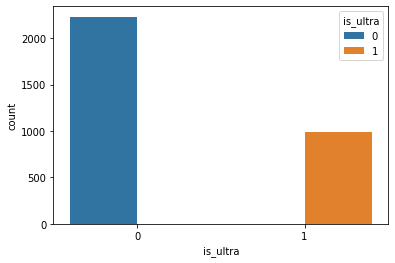

In [50]:
sns.countplot(x=df['is_ultra'], hue=df['is_ultra'])
plt.show()

In [51]:
print('Smart -', '{}%'.format((df.query('is_ultra == 0')['is_ultra'].count() / df.shape[0]).round(2)))
print('Ultra -', '{}%'.format((df.query('is_ultra == 1')['is_ultra'].count() / df.shape[0]).round(2)))

Smart - 0.69%
Ultra - 0.31%


По данному графику видно, что количество пользователей тарифа смарт(0) в два с лишним раза больше чем пользователей тарифа ультра(1).

In [52]:
df.groupby('is_ultra').mean().round(0)

,calls,minutes,messages,mb_used
is_ultra,,,,
0,58.0,406.0,33.0,16208.0
1,73.0,511.0,49.0,19469.0


In [53]:
#округлим данные до целых и приведем данные к нужному типу
df = df.astype({'calls': 'int64', 'minutes': 'int64', 'messages': 'int64', 'mb_used': 'int64'})
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40,311,83,19915,0
1,85,516,56,22696,0
2,77,467,86,21060,0
3,106,745,81,8437,1
4,66,418,1,14502,0
...,...,...,...,...,...
3209,122,910,20,35124,1
3210,25,190,0,3275,0
3211,97,634,70,13974,0
3212,64,462,90,31239,0


In [54]:
#убедимся в измении типа данных
df.dtypes

calls       int64
minutes     int64
messages    int64
mb_used     int64
is_ultra    int64
dtype: object

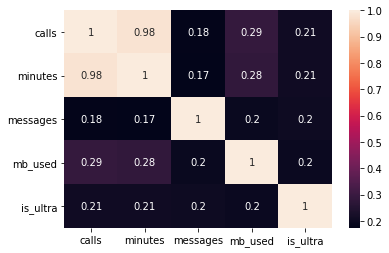

In [55]:
#посмотрим влияние/ зависимость разных параметров
sns.heatmap(df.corr(), annot=True)
plt.show()

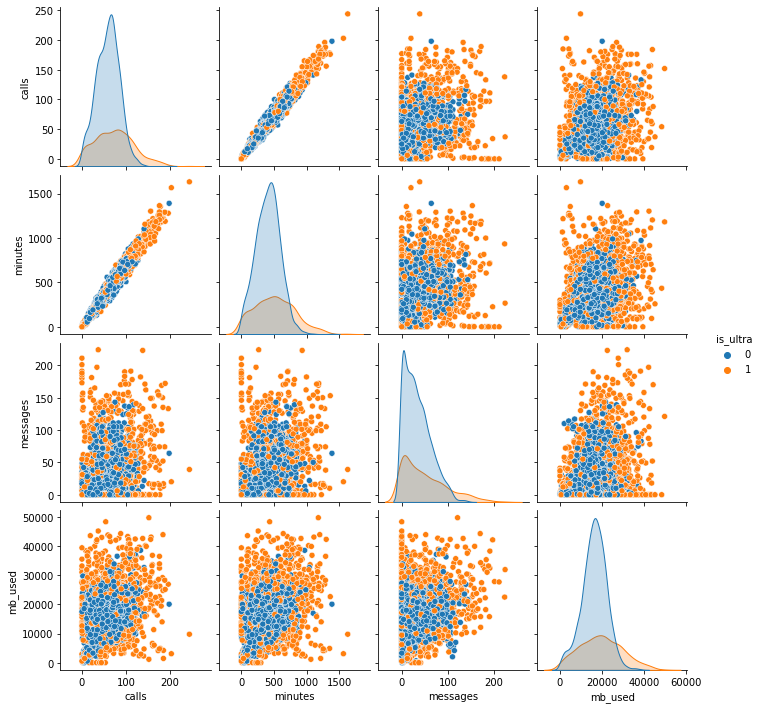

In [56]:
sns.pairplot(df, hue='is_ultra')
plt.show()

По данным графикам видим прямую зависимость между длительностью звонков в минутах и количеством звонков. 

In [57]:
#посмотрим показатели по всем данным
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,437.717797,38.281269,17207.186683,0.306472
std,33.236368,234.559661,36.148326,7570.972211,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.000000,9.000000,12491.250000,0.000000
50%,62.000000,430.000000,30.000000,16943.000000,0.000000
75%,82.000000,571.750000,57.000000,21424.000000,1.000000
max,244.000000,1632.000000,224.000000,49745.000000,1.000000


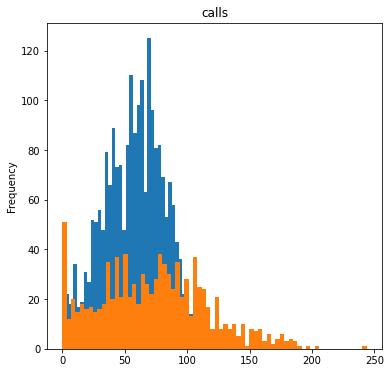

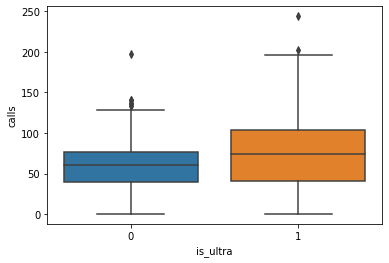

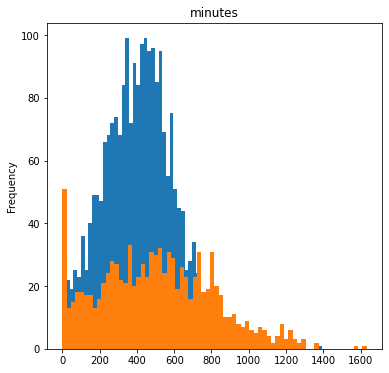

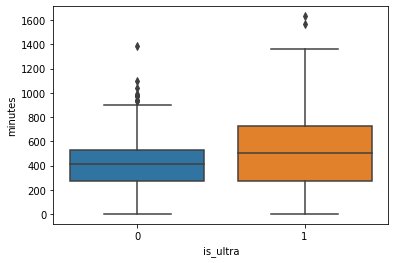

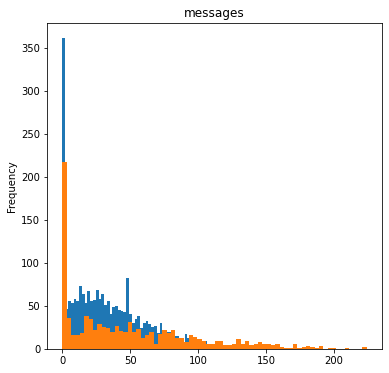

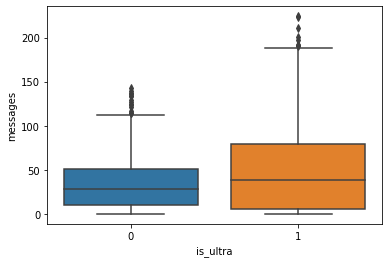

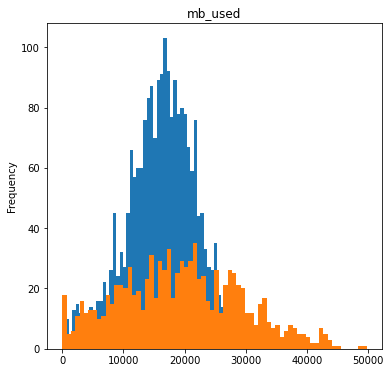

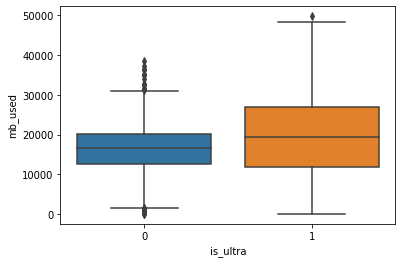

In [58]:
#посмотрим на распределение данных по разным тарифам
col = ['calls', 'minutes', 'messages', 'mb_used']
for column in col:
    df.groupby('is_ultra')[column].plot(kind='hist', bins=70, figsize=(6, 6))
    plt.title(column)
    plt.show()
    sns.boxplot(x='is_ultra', y=column, data=df)
    plt.show()

По данным графикам видно, что по всем параметрам данных присутствуют выбросы. Также можно заметить, что по параметрам количества звонков (calls), количества минут разговора (minutes), количество sms сообщений (message), а также использования интернета (mb_used) есть значения равные 0. Низкий показатель, в частности 0 сообщений, может быть связан с низким использованием данных способов общения, так как в данный момент есть соц. сети, где и происходит общение методом переписки. Также стоит рассмотреть такой вариант, что пользователи у которых нет звонков и нет минут разговора, используют средства связи только из-за возможности интернет соединения.

In [59]:
#сделаем срез по данным по столбцу звонков равному 0
df_drop_calls = df.query('calls == 0')
df_drop_calls

,calls,minutes,messages,mb_used,is_ultra
54,0,0,33,14010,1
247,0,0,35,16444,1
264,0,0,21,19559,0
351,0,0,8,35525,1
390,0,0,25,19088,1
484,0,0,191,32448,1
551,0,0,24,18701,1
647,0,0,30,10236,1
769,0,0,32,17206,0
884,0,0,180,32045,1


### Вывод по блоку

Все признаки для машинного обучения являются не категориальными, то есть непрерывные. К категориальным относится только целевой признак столбец 'is_smart'. Для решения данной задачи будем использовать методы классификации, в частности для данной задачи бинарная классификация. Была определена прямая зависимость между такими парами признаков как: количество звонков и количество минут разговора. Также определили, что распределение по бинарной категории столбца 'is_smart' не пропорциональны друг к другу (Smart:Ultra), то есть не 1:1, а 2:1. Есть незначительные выбросы (шумы) по данным. Следует учесть, что все эти факторы могут сказаться на правильном обучении и дальнейшем предсказании модели.

## Разобьем данные на выборки

In [60]:
#определим признаки (фичи) - X и целевой признак - y
X = df.drop(columns=['is_ultra'])
y = df['is_ultra']

#разобьем данные на обучающую, валидационную и тестовую
#выделим под тест и валидацию 40% данных
train_X, test_val_X, train_y, test_val_y = train_test_split(X, y, test_size=0.4, random_state=True)

#выделим валидациооную и тестовую части
#разделим test на валидацию и тестовую выборки
val_X, test_X, val_y, test_y = train_test_split(test_val_X, test_val_y, test_size=0.5, random_state=True)

In [61]:
#убедимся в разделении данных на выборки
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(1928, 4)
(643, 4)
(643, 4)


### Вывод по блоку

Разделили датасет на обучающую, валидационную и тестовую выборки.
Датасет разделили в следующих пропорциях:

- 20% - тестовая выборка;
- 20% - валидационная выборка;
- 60% - обучающая выборка.

## Исследуем модели

### Рассмотрим модель дерево решений

In [70]:
accur_model_dtc = []
best_model_dtc = None
best_result = 0
best_depth = 0
for depth in range(1, 16):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dtc.fit(train_X, train_y)
    predictions = model_dtc.predict(val_X)
    result = accuracy_score(val_y, predictions)
    accur_model_dtc.append(result.round(2))
    if result > best_result:
        best_model_dtc = model_dtc
        best_result = result
        best_depth = depth

print('Accuracy лучшей модели на валидационной выборке:', best_result.round(2))
print('Глубина дерева у лучшей модели:', best_depth)
print(accur_model_dtc)

Accuracy лучшей модели на валидационной выборке: 0.79
Глубина дерева у лучшей модели: 9
[0.72, 0.76, 0.77, 0.77, 0.77, 0.77, 0.78, 0.78, 0.79, 0.78, 0.79, 0.78, 0.79, 0.77, 0.78]


Для модели дерева решений лучший показатель accuracy составляет 0.79 и глубина дерева равная 9. Как можно видеть из списка accur_model_dtc показатель accuracy снижается 0,79 => 0,7, возможно это говорит о переобучении модели.

### Рассмотрим модель случайный лес

In [63]:
accur_model_rfc = []
best_model_rfc = None
best_result = 0
best_depth = 0
for est in range(10, 150, 10):
    accur_model_rfc.append('|')
    for depth in range(1, 8):
        model_rfc = RandomForestClassifier(random_state=23456, n_estimators=est, max_depth=depth)
        model_rfc.fit(train_X, train_y)
        predictions = model_rfc.predict(val_X)
        result = accuracy_score(val_y, predictions)
        accur_model_rfc.append(result.round(2))
        if result > best_result:
            best_model_rfc = model_rfc
            best_result = result
            best_est = est
            best_depth = depth

print('Accuracy лучшей модели на валидационной выборке:', best_result.round(2))
print('Количество деревьев:', best_est, 'Глубина дерева у лучшей модели:', best_depth)
print(accur_model_rfc)

Accuracy лучшей модели на валидационной выборке: 0.8
Количество деревьев: 20 Глубина дерева у лучшей модели: 7
['|', 0.72, 0.77, 0.77, 0.78, 0.78, 0.79, 0.79, '|', 0.72, 0.76, 0.77, 0.78, 0.78, 0.79, 0.8, '|', 0.72, 0.76, 0.77, 0.78, 0.78, 0.79, 0.79, '|', 0.72, 0.76, 0.78, 0.78, 0.78, 0.79, 0.79, '|', 0.72, 0.76, 0.77, 0.77, 0.78, 0.78, 0.79, '|', 0.72, 0.76, 0.77, 0.78, 0.79, 0.79, 0.79, '|', 0.72, 0.76, 0.77, 0.77, 0.79, 0.79, 0.79, '|', 0.71, 0.76, 0.77, 0.77, 0.78, 0.79, 0.8, '|', 0.71, 0.76, 0.78, 0.77, 0.78, 0.79, 0.8, '|', 0.71, 0.76, 0.78, 0.77, 0.78, 0.79, 0.79, '|', 0.71, 0.76, 0.77, 0.77, 0.78, 0.79, 0.79, '|', 0.71, 0.76, 0.77, 0.77, 0.78, 0.79, 0.79, '|', 0.72, 0.76, 0.77, 0.77, 0.78, 0.79, 0.79, '|', 0.72, 0.76, 0.77, 0.77, 0.78, 0.79, 0.79]


Для модели случайного леса лучший показатель accuracy составляет 0.8, глубина дерева равная 7 и количество деревьев равна 20.

### Рассмотрим модель логистичнеской регрессии

In [64]:
model_lr = LogisticRegression(random_state=34567, solver='lbfgs', max_iter=1000)
model_lr.fit(train_X, train_y)
predictions_lr = model_lr.predict(val_X)
result_lr = accuracy_score(val_y, predictions_lr)            
print('Accuracy модели на валидационной выборке:', result_lr.round(2))

Accuracy модели на валидационной выборке: 0.72


Для модели логистической регрессии показатель accuracy составил 0,72.

### Вывод по блоку

Исходя из показателя accuracy для решения данной задачи классификации следует выбрать модель случайного леса, с количеством деревьев равному 20 и глубиной дерева равному 7.

## Проверим модель на тестовой выборке

In [65]:
predict_best = best_model_rfc.predict(test_X)
print('Показатель accuracy на тестовой выборке с лучшей моделью составляет:', 
      accuracy_score(test_y, predict_best).round(2))

Показатель accuracy на тестовой выборке с лучшей моделью составляет: 0.8


Хороший показатель accuracy на тестовой выборке.

## Проверим модели на адекватность

In [69]:
#для проверки модели на адекватность воспользуемся оценкой качества прогнозов с помощью DummyClassifier
train_val_X = [train_X, val_X]
train_val_y = [train_y, val_y]
dc_X = pd.concat(train_val_X)
dc_y = pd.concat(train_val_y)
clf = DummyClassifier()
scores = cross_val_score(clf, dc_X, dc_y, scoring='accuracy')
print('Показатель accuracy DummyClassifier =', scores.mean().round(2))

Показатель accuracy DummyClassifier = 0.69


## Общий вывод

В данной работе рассмотрели модели машинного обучения с учителем на примере решения задачи рекомендации тарифов, предварительно разбив весь датасет на части: обучение, валидация и тестовая выборка. Для решения данной задачи использовали модели классификации, в частности модели дерева решений, случайный лес и логистическая регрессия. 

Изменяя гиперпараметры, определили наилучшую модель для поставленной задачи. Лучше всего справилась модель случайного леса, хуже всего оказалась модель логистической регрессии. Проверили наилучшую модель случайного леса с гиперпараметрами глубиной дерева 7 и количеством деревьев 20 и получили на тестовой выборке показатель accuracy равным 0.8, тогда как на валидациооной выборке accuracy = 0.8.

Для оценки адекватности нашей модели сравнили с моделью где использовали DummyClassifier (классификатор для определения прогнозов с помощью простых правил), который показал accuracy = 0.69, что меньше нашей лучшей модели. 

Исходя из всего, для построения системы предложения тарифов следует рассматривать модель случайного леса с гиперпараметрами глубиной дерева 7 и количеством деревьев 20.